In [1]:
from __future__ import unicode_literals

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

# Set plotting style
plt.style.use('seaborn-white')

%matplotlib inline

In [2]:
# Date conversion function
def date_columns(query):
    """If a date column is included in the query, parse it as a date in the
    dataframe."""
    dates = []
    fields = ["Collision_Date", "Process_Date"]
    if '*' in query:
        dates = fields
    else:
        for date in fields:
            if date in query:
                dates.append(date)

        if not dates:
            dates = None

    return dates

In [3]:
def run_query(query, sql_file="./switrs.sqlite3"):
    """ Read sqlite query results into a pandas DataFrame. """
    with sqlite3.connect(sql_file) as con:
        # Construct a Dataframe from the results
        df = pd.read_sql_query(
            query,
            con,
            parse_dates = date_columns(query),
        )

        return df

# Crashes by Week

Let's start by looking at the number of incidents per month:

In [4]:
query = (
    "SELECT Collision_Date "
    "FROM Collision AS C "
    "WHERE Collision_Date IS NOT NULL "
    "AND Collision_Date <= '2015-12-31' "  # 2016 is incomplete
)

df = run_query(query)

In [5]:
DATE_COL = "Collision_Date"
CRASH_COL = "Crashes"

df["DOY"]     = df[DATE_COL].dt.dayofyear
df["DOW"]     = df[DATE_COL].dt.dayofweek
df["Day"]     = df[DATE_COL].dt.day
df["Week"]    = df[DATE_COL].dt.week
df["Month"]   = df[DATE_COL].dt.month
df["Year"]    = df[DATE_COL].dt.year
df[CRASH_COL] = 1

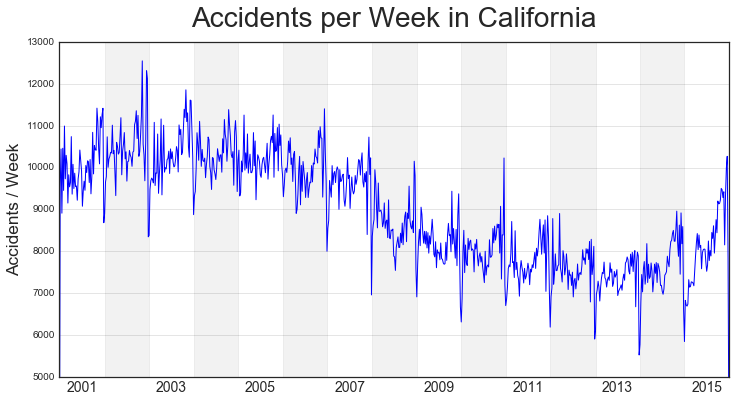

In [6]:
# Convert to a timeseries
ts = df[[DATE_COL]]
ts.index= ts[DATE_COL]
ax = ts.resample('W-MON').count()[DATE_COL].plot(
    kind="line",
    title='Accidents in California',
    figsize=(12,6),
    linewidth=1,
)

# Set Y range and grid
ax.set_ylim([5000, 13000])
ax.grid()

# Set axis labels
plt.title('Accidents per Week in California', y=1.03, size=28)
FONTSIZE="xx-large"
plt.xlabel("")
plt.ylabel("Accidents / Week", fontsize=FONTSIZE)

# Set the year between the tick marks using minor ticks
# Pandas uses a obscure Axis labeling system, so to put the ticks between the
# major ticks, we interpolate it using np.interp().
y = ax.get_xticks()
x = [2001] + list(range(2002, 2018, 2))  # Step of 2 means every other year
minor_x = np.interp(np.arange(2001.5, 2016.5, 2), x, y)
ax.set_xticks(minor_x, minor=True)
ax.set_xticklabels(np.arange(2001, 2016, 2), minor=True, size=14)
ax.set_xticks([])  # Unset major ticks

# Add shaded bands for every other year
for year in range(2002, 2017, 2):
    ax.axvspan(pd.to_datetime(str(year)), pd.to_datetime(str(year+1)), color="black", alpha=0.05)

plt.savefig("/tmp/accidents_per_week_in_california.svg", bbox_inches='tight')
plt.savefig("/tmp/accidents_per_week_in_california.png", bbox_inches='tight')
plt.show()


# Grouped by Day of the Year

In [7]:
from datetime import datetime

def annotate_year(df, ax, month, day, text, xytext, adjust=(0, 0), arrowstyle="->"):
    """ Draw an annotation on the Day of Year plot. """
    # Use 2015 because it is a non-leapyear, and most years are non-leap year
    doy = datetime(year=2015, month=month, day=day).timetuple().tm_yday
    y_pos = df[CRASH_COL][month][day]

    ax.annotate(
        text,
        (doy+adjust[0], y_pos+adjust[1]),
        xytext=xytext,
        textcoords='offset points',
        arrowprops=dict(
            arrowstyle=arrowstyle,
            connectionstyle="arc3",
        ),
        size=16,
        color='k',
    )

In [8]:
# Get the start locations of each month
def month_starts(df):
    """ Get the start and midpoints of each month. """
    # Month starts
    majors = []
    for x, (month, day) in enumerate(df.index):
        if day == 1:
            majors.append(x)
        if month == 12 and day == 31:
            majors.append(x)

    # Midpoints
    minors = []
    for i in range(len(majors)-1):
        end = majors[i+1]
        start = majors[i]
        x = start + (end-start)/2.
        minors.append(x)

    return (majors, minors)

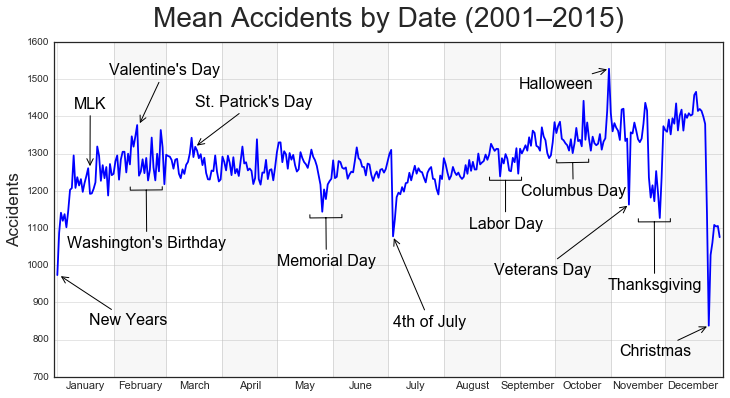

In [9]:
# Calculate crashes per day
mean_crashes = df.groupby(("Month", "Day")).count()
mean_crashes[CRASH_COL] /= 15  # Average instead of sum of years
mean_crashes[CRASH_COL][2][29] = mean_crashes[CRASH_COL][2][29] * 15/3.  # Only 3 leap years!

ax = mean_crashes[CRASH_COL].plot(
    kind="line",
    linewidth=1.8,
    figsize=(12,6),
)

# Set Y Range and grid
ax.set_ylim([700, 1600])
ax.set_xlim([-2, 367])  # Avoid hiding the start/end points
ax.grid()

# Set axis labels
plt.title('Mean Accidents by Date (2001–2015)', y=1.03, size=28)
FONTSIZE="xx-large"
plt.xlabel('')
plt.ylabel("Accidents", fontsize=FONTSIZE)

# Fix the X tick labels
(major_x, minor_x) = month_starts(mean_crashes)
labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
ax.set_xticks(major_x[:-1])
ax.set_xticklabels([])
ax.set_xticks(minor_x, minor=True)
ax.set_xticklabels(labels, minor=True, size=11)

# Shade every other month
for i in range(0, len(major_x)-1, 2):
    start = major_x[i+1]
    end = major_x[i+2]
    ax.axvspan(start, end, color="black", alpha=0.03)

# Federal Holidays
annotate_year(mean_crashes, ax, 1, 1, "New Years", (30, -50))
annotate_year(mean_crashes, ax, 1, 18, "MLK", (-16, 60))
annotate_year(mean_crashes, ax, 2, 18, "Washington's Birthday", (-79, -60), (0, -40), arrowstyle="-[")
annotate_year(mean_crashes, ax, 5, 28, "Memorial Day", (-49, -50), (0, -45), arrowstyle="-[")
annotate_year(mean_crashes, ax, 7, 4, "4th of July", (0, -90))
annotate_year(mean_crashes, ax, 9, 4, "Labor Day", (-37, -50), (0, -65), arrowstyle="-[")
annotate_year(mean_crashes, ax, 10, 11, "Columbus Day", (-52, -35), (0, -20), arrowstyle="-[")
annotate_year(mean_crashes, ax, 11, 11, "Veterans Day", (-135, -70))
annotate_year(mean_crashes, ax, 11, 25, "Thanksgiving", (-47, -70), (0, -50), arrowstyle="-[")
annotate_year(mean_crashes, ax, 12, 25, "Christmas", (-90, -30))

# Other Holidays
annotate_year(mean_crashes, ax, 10, 31, "Halloween", (-90, -20))
annotate_year(mean_crashes, ax, 2, 14, "Valentine's Day", (-30, 50))
annotate_year(mean_crashes, ax, 3, 17, "St. Patrick's Day", (0, 40))

plt.savefig("/tmp/mean_accidents_by_date.svg", bbox_inches='tight')
plt.savefig("/tmp/mean_accidents_by_date.png", bbox_inches='tight')
plt.show()

# Weekends

In [10]:
# Count accidents per day, and then reset the index so we can pivot on the index
DOW_COL = "DOW"

df_dow = df[[DATE_COL, DOW_COL, "Crashes"]].groupby([DATE_COL, DOW_COL]).count()
df_dow = df_dow.reset_index()

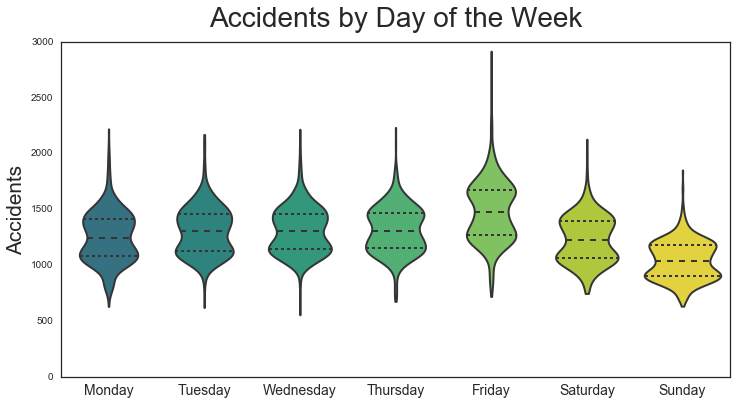

In [11]:
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-white')

# Set plot size
fig = plt.gcf()
fig.set_size_inches(12, 6)

colors = cm.viridis(np.linspace(0.4, 1, 7))
ax = sns.violinplot(
    x="DOW",
    y="Crashes",
    data=df_dow,
    linewidth=2,
    cut=0,
    inner="quartile",
    palette=colors,
)

# Set plot title
plt.title('Accidents by Day of the Week', y=1.03, size=28)

# Set Y and X range
plt.gca().set_ylim([0, 3000])
#plt.gca().set_xlim([-0.5, 6.5])
plt.ylabel("Accidents", fontsize=FONTSIZE)
plt.xlabel("")

# Set X tick labels
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], size=14)

plt.savefig("/tmp/accidents_by_day_of_the_week.png", bbox_inches='tight')
plt.savefig("/tmp/accidents_by_day_of_the_week.svg", bbox_inches='tight')
plt.show()